This work has partly been published in N. Kalb et al., PRA 97, 062230 (2018).

In [11]:
import numpy as np
from matplotlib import pyplot as plt
import src.QMC_simulation as QMC
import src.analytic_model as analytic
%matplotlib inline

## Analytic simulation for pure repumping noise

We find the numerical coefficient for decay(p_\ket{1} = 0.5) / decay(p_\ket{1} = 1.0) to be approx. 2.
See main publication, section VI, Paragraph 5.

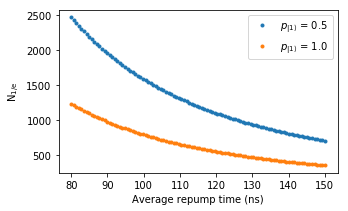

Relative performance for f(p = 0.5) / f(p = 1.0) over relevant parameter range: 2.0009


In [12]:
#params
repump_times = np.linspace(80., 150., 100) * 1e-9#in s

## init simulations:
params = {'average_repump_time': repump_times, 'pflip': 0.5}
ana05 = analytic.Faraday(params = params)
params.update({'pflip': 1.0})
ana10 = analytic.Faraday(params = params)

#calc results
y05 = ana05.faraday_decay_constant()
y10 = ana10.faraday_decay_constant()

## prep labels
str05 = r'$p_{|1\rangle}$' + ' = {:0.1f}'.format(0.5)
str1 = r'$p_{|1\rangle}$' + ' = {:0.1f}'.format(1.0)

# display
fig = plt.figure(figsize = (5,3))
plt.plot(repump_times * 1e9, y05, '.', label = str05)
plt.plot(repump_times * 1e9, y10, '.', label = str1)
plt.legend()
plt.xlabel('Average repump time (ns)')
plt.ylabel(r'$\mathrm{N_{1/e}}$')
plt.show()

# Determine benchmark number
ans = np.average(y05 / y10)
print('Relative performance for f(p = 0.5) / f(p = 1.0) over relevant parameter range: {:.4f}'.format(ans))

## Comparison: MC simulation vs. analytic result

Run MC simulation without additional sources of error.
Should be consistent with analytic model. 

In [13]:
params = {
    'mw_infidelity': 0.0,
    'init_infidelity': 0.0,
}

mc_sim = QMC.QMC(params = params)
mc_sim.compute_fidelity_from_scratch()

x = np.arange(0,mc_sim.get_param('entangling_attempts'))
params.update({'entangling_attempts' : x})
analytic_sim = analytic.Faraday(params = params)
analytic_sim.get_carbon_state_fidelity()

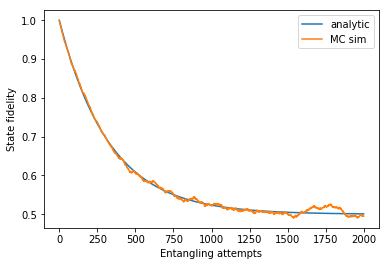

In [14]:
plt.plot(x, analytic_sim.cspin_fidelity, label = 'analytic')
plt.plot(np.array(x),mc_sim.cspin_fidelity, label = 'MC sim')
plt.legend()
plt.xlabel('Entangling attempts')
plt.ylabel('State fidelity')
plt.show()

## Fig. 5b: 2D sweep MW infidelity vs. repumping infidelity

In [18]:
#settings
params = {
    #carbon params
    'coupling'            : 26e3, 
    
    # nv params
    'average_repump_time' : 100e-9,
    'repump_time_jitter'  : 0.0,    
    'repump_time_offset'  : 0.0,  
    'pflip'               : 0.5,
    
    # sim/sequence params
    'entangling_attempts' : 20000,
    'repetitions'         : 600,
    'T'                   : 100e-9,
    'larmor_period'       : 2.256e-6,
    'larmor_order'        : 1,
}

In [19]:
#sweep range
mw_infids = np.logspace(-5,-2,num=15) 
init_infids = np.logspace(-5,-2,num=12) 
res_low_mag = np.zeros((len(mw_infids),len(init_infids)))
res_high_mag = np.zeros((len(mw_infids),len(init_infids)))


mc_sim = QMC.QMC(params = params)
# Executing this piece of code takes quite some time.
if False:
    print 'progress: ',
    
    for ii,mw in enumerate(mw_infids):
        mc_sim.set_param('mw_infidelity', mw)
        for jj,init in enumerate(init_infids):
            mc_sim.set_param('init_infidelity', init)
            
            # low magnetic field
            mc_sim.set_param('larmor_period', 2.256e-6) # magnetic field: B = 414 G
            mc_sim.compute_fidelity_from_scratch()
            decay_const = mc_sim.find_attempts_from_fidelity(0.5 + 0.5 / np.exp(1)) 
            res_low_mag[ii,jj] = decay_const
            
            
            # high magnetic field
            mc_sim.set_param('larmor_period', 0.2256e-6) # magnetic field: B = 4140 G
            mc_sim.compute_fidelity_from_scratch()
            decay_const = mc_sim.find_attempts_from_fidelity(0.5 + 0.5 / np.exp(1)) 
            res_high_mag[ii,jj] = decay_const
        print '{}/{} '.format(ii + 1, len(mw_infids)),

In [22]:
import pickle
### save new MC results
if False:
    filename = 'myFileName.p'
    pickle_dict = {}
    pickle_dict['res_low_mag']  = res_low_mag
    pickle_dict['res_high_mag'] = res_high_mag
    pickle_dict['mw_infids']    = mw_infids
    pickle_dict['init_infids']  = init_infids
    fileOut = open(filename, "wb")
    pickle.dump(pickle_dict, fileOut)
    fileOut.close()
    
### load previous MC results
if True:
    filename = 'MC_2D_data.p'
    pickle_dict = pickle.load(open(filename, "r" ))
    res_low_mag = pickle_dict['res_low_mag']
    res_high_mag = pickle_dict['res_high_mag'] 
    mw_infids = pickle_dict['mw_infids']
    init_infids = pickle_dict['init_infids']

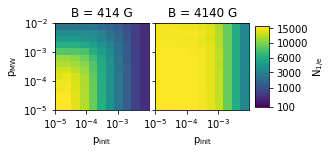

In [26]:
from matplotlib import colors, cm

X,Y = np.meshgrid(init_infids, mw_infids)

fig,axs = plt.subplots(1, 2, sharey = True,
                       figsize = (4, 1.6)) #size according to journal guidelines PRA

for ii,r in enumerate([res_low_mag,res_high_mag]):
    plt.sca(axs[ii])
    pcm = plt.pcolormesh(X,Y,r,
                       cmap = cm.viridis,
                       norm = colors.PowerNorm(gamma = 1. / 2.),
                       vmin = 100)
    
    #subplt formatting
    plt.xscale("log", nonposx = 'clip')
    plt.yscale("log", nonposy = 'clip')
    plt.xticks([1e-3, 1e-4, 1e-5])
    plt.yticks([1e-2, 1e-3, 1e-4, 1e-5])
    plt.xlabel(r'$\mathrm{p_{init}}$')
    plt.title('B = 414'+ ii*'0' + ' G')
    plt.minorticks_off()
    
    if not ii:
        plt.ylabel(r'$\mathrm{p_{MW}}$')

# final formatting: color bar and subplot spacing.
ticks = [100, 1000, 3000, 6000, 10000, 15000]
fig.subplots_adjust(wspace = 0.07,right = 0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.05, 0.7])
fig.colorbar(pcm, cax = cbar_ax, orientation = 'vertical',
             label = r'$\mathrm{N_{1/e}}$', ticks = ticks)
plt.show()